## Part1 (TSP)

### Set up

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import re
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time

In [3]:
import seaborn as sns

In [4]:
def ht(df, n = 5):
    print(df.shape)
    if len(df) <= 2*n:
        display(df)
    else:
        display(df.head(n).append(df.tail(n)))

In [5]:
pd.set_option('display.max_columns', 100)
def pf(df):
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')

In [6]:
plt.style.use('seaborn')
# plt.rcParams['figure.figsize'] = [16, 9]

In [7]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [8]:
random_seed = hash('jcha64') % (2 ** 32)

In [9]:
random_seed_list = [199, 197, 193, 191, 181, 179, 173, 167, 163, random_seed]

In [10]:
def RHC_HP(restarts, max_attempts, N, random_seed_list=[199, 197, 193, 191, 181, 179, 173, 167, 163, random_seed]):
    best_fitness_list = []
    wall_clock_time_list = []    
    for i in range(len(random_seed_list)):
        start = time.time()
        best_state, best_fitness, fitness_curve = mlrose.random_hill_climb(
            problem, 
            max_attempts=eval(max_attempts), 
            max_iters=5000, 
            restarts=eval(restarts), 
            init_state=init_state, 
            curve=True, 
            random_state=random_seed_list[i]
        )
        end = time.time()
        df = DataFrame(fitness_curve)
        df['iter'] = range(len(df))
        df['try'] = i
        df['hyper'] = f'restarts={restarts}, max_attempts={max_attempts}'
        df['RO'] = 'RHC'
        df['N'] = N
        df.columns = ['fitness', 'iter', 'try', 'hyper', 'RO', 'N']
        df_fitness_curve_list.append(df)
        best_fitness_list.append(best_fitness)
        wall_clock_time_list.append(end-start)
    return best_fitness_list, wall_clock_time_list

def SA_HP(init_temp, exp_const, max_attempts, N, random_seed_list=[199, 197, 193, 191, 181, 179, 173, 167, 163, random_seed]):
    best_fitness_list = []
    wall_clock_time_list = []    
    for i in range(len(random_seed_list)):
        start = time.time()
        best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(
            problem, 
            schedule = mlrose.ExpDecay(init_temp = eval(init_temp), exp_const=eval(exp_const), min_temp=1e-10),
            max_attempts = eval(max_attempts), 
            max_iters = 5000,
            init_state = init_state, 
            random_state = random_seed_list[i], 
            curve = True
        )
        end = time.time()
        df = DataFrame(fitness_curve)
        df['iter'] = range(len(df))
        df['try'] = i
        df['hyper'] = f'T={init_temp},r={exp_const},max_attempts={max_attempts}'
        df['RO'] = 'SA'
        df['N'] = N
        df.columns = ['fitness', 'iter', 'try', 'hyper', 'RO', 'N']
        df_fitness_curve_list.append(df)
        best_fitness_list.append(best_fitness)
        wall_clock_time_list.append(end-start)
    return best_fitness_list, wall_clock_time_list

def GA_HP(pop_size, mut_prob, max_attempts, N, random_seed_list=[199, 197, 193, 191, 181, 179, 173, 167, 163, random_seed]):
    best_fitness_list = []
    wall_clock_time_list = []
    for i in range(len(random_seed_list)):
        start = time.time()
        best_state, best_fitness, fitness_curve = mlrose.genetic_alg(
            problem, 
            pop_size = eval(pop_size),
            mutation_prob=eval(mut_prob), 
            max_attempts=eval(max_attempts), 
            max_iters=5000, 
            random_state = random_seed_list[i], 
            curve = True
        )
        end = time.time()
        df = DataFrame(fitness_curve)
        df['iter'] = range(len(df))
        df['try'] = i
        df['hyper'] = f'pop_size={pop_size},mut_prob={mut_prob},max_attempts={max_attempts}'
        df['RO'] = 'GA'
        df['N'] = N
        df.columns = ['fitness', 'iter', 'try', 'hyper', 'RO', 'N']
        df_fitness_curve_list.append(df)
        best_fitness_list.append(best_fitness)
        wall_clock_time_list.append(end-start)
    return best_fitness_list, wall_clock_time_list        

def MIMIC_HP(pop_size, keep_pct, max_attempts, N, random_seed_list=[199, 197, 193, 191, 181, 179, 173, 167, 163, random_seed], fast_mimic=True):
    best_fitness_list = []
    wall_clock_time_list = []
    for i in range(len(random_seed_list)):
        start = time.time()
        best_state, best_fitness, fitness_curve = mlrose.mimic(
            problem, 
            pop_size=eval(pop_size), 
            keep_pct=eval(keep_pct), 
            max_attempts=eval(max_attempts), 
            max_iters=5000, 
            curve=True, 
            random_state=random_seed_list[i], 
            fast_mimic=fast_mimic
        )
        end = time.time()
        df = DataFrame(fitness_curve)
        df['iter'] = range(len(df))
        df['try'] = i
        df['hyper'] = f'pop_size={pop_size},keep_pct={keep_pct},max_attempts={max_attempts}'
        df['RO'] = 'MIMIC'
        df['N'] = N
        df.columns = ['fitness', 'iter', 'try', 'hyper', 'RO', 'N']
        df_fitness_curve_list.append(df)
        best_fitness_list.append(best_fitness)
        wall_clock_time_list.append(end-start)
    return best_fitness_list, wall_clock_time_list

### TSP

#### Problem definition

In [11]:
coords_list_base = [(1, 1), (4, 2), (5, 2), (6, 4), (4, 4), (3, 6), (1, 5), (2, 3)]
coords_list = [(p[0]+i*10,p[1]+i*10) for i in range(4) for p in coords_list_base]
N = len(coords_list)
fitness = mlrose.TravellingSales(coords = coords_list)

In [12]:
np.random.seed(random_seed_list[-1])
init_state = np.random.permutation(N)

In [13]:
fitness.evaluate(init_state)

582.7856321778225

In [14]:
problem = mlrose.TSPOpt(length = N, fitness_fn = fitness, maximize=False)

#### RHC

In [15]:
df_fitness_curve_list = []

In [16]:
best_fitness_list, wall_clock_time_list = RHC_HP(restarts='0', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

356.0521202177955
0.033425188064575194


In [17]:
best_fitness_list, wall_clock_time_list = RHC_HP(restarts='0', max_attempts='100', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

167.10780224479922
0.33330161571502687


In [18]:
df_fitness_curve = pd.concat(df_fitness_curve_list)
ht(df_fitness_curve)

(8318, 6)


,fitness,iter,try,hyper,RO,N
0,-580.542592,0,0,"restarts=0, max_attempts=10",RHC,32
1,-580.542592,1,0,"restarts=0, max_attempts=10",RHC,32
2,-580.542592,2,0,"restarts=0, max_attempts=10",RHC,32
3,-580.542592,3,0,"restarts=0, max_attempts=10",RHC,32
4,-580.542592,4,0,"restarts=0, max_attempts=10",RHC,32
1106,-124.398058,1106,9,"restarts=0, max_attempts=100",RHC,32
1107,-124.398058,1107,9,"restarts=0, max_attempts=100",RHC,32
1108,-124.398058,1108,9,"restarts=0, max_attempts=100",RHC,32
1109,-124.398058,1109,9,"restarts=0, max_attempts=100",RHC,32
1110,-124.398058,1110,9,"restarts=0, max_attempts=100",RHC,32


Text(0.5, 1.0, 'TSP RHC HP tuning')

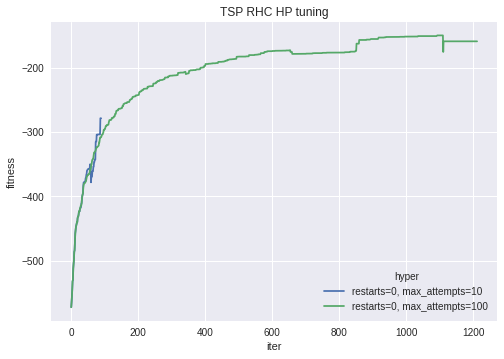

In [19]:
sns.lineplot(data=df_fitness_curve.reset_index(), x="iter", y="fitness", hue="hyper", ci=None).set_title('TSP RHC HP tuning')

#### SA

In [ ]:
df_fitness_curve_list = []

In [ ]:
best_fitness_list, wall_clock_time_list = SA_HP(init_temp='1e10', exp_const='0.999', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
best_fitness_list, wall_clock_time_list = SA_HP(init_temp='1e10', exp_const='0.5', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [23]:
best_fitness_list, wall_clock_time_list = SA_HP(init_temp='1e5', exp_const='0.999', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

349.35002999644655
0.0438018798828125


In [24]:
best_fitness_list, wall_clock_time_list = SA_HP(init_temp='1e5', exp_const='0.5', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

378.15301431649266
0.048122310638427736


In [25]:
df_fitness_curve = pd.concat(df_fitness_curve_list)
ht(df_fitness_curve)

(3365, 6)


,fitness,iter,try,hyper,RO,N
0,-580.542592,0,0,"T=1e10,r=0.999,max_attempts=10",SA,32
1,-659.233615,1,0,"T=1e10,r=0.999,max_attempts=10",SA,32
2,-665.670497,2,0,"T=1e10,r=0.999,max_attempts=10",SA,32
3,-648.366758,3,0,"T=1e10,r=0.999,max_attempts=10",SA,32
4,-642.814829,4,0,"T=1e10,r=0.999,max_attempts=10",SA,32
77,-330.857215,77,9,"T=1e5,r=0.5,max_attempts=10",SA,32
78,-330.857215,78,9,"T=1e5,r=0.5,max_attempts=10",SA,32
79,-330.857215,79,9,"T=1e5,r=0.5,max_attempts=10",SA,32
80,-330.857215,80,9,"T=1e5,r=0.5,max_attempts=10",SA,32
81,-330.857215,81,9,"T=1e5,r=0.5,max_attempts=10",SA,32


Text(0.5, 1.0, 'TSP SA HP tuning')

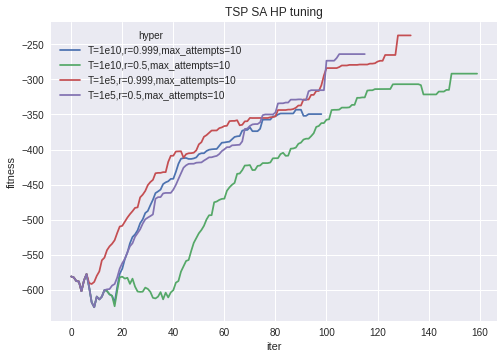

In [26]:
sns.lineplot(data=df_fitness_curve.reset_index(), x="iter", y="fitness", hue="hyper", ci=None).set_title('TSP SA HP tuning')

#### MIMIC

In [27]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='100', keep_pct='0.01', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

452.739324545077
4.801288175582886


In [28]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='100', keep_pct='0.02', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

452.739324545077
4.822001433372497


In [29]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='100', keep_pct='0.04', max_attempts='10', N=N)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

429.15342161645106
4.9704447984695435


In [30]:
df_fitness_curve = pd.concat(df_fitness_curve_list)
ht(df_fitness_curve)

(3701, 6)


,fitness,iter,try,hyper,RO,N
0,-580.542592,0,0,"T=1e10,r=0.999,max_attempts=10",SA,32
1,-659.233615,1,0,"T=1e10,r=0.999,max_attempts=10",SA,32
2,-665.670497,2,0,"T=1e10,r=0.999,max_attempts=10",SA,32
3,-648.366758,3,0,"T=1e10,r=0.999,max_attempts=10",SA,32
4,-642.814829,4,0,"T=1e10,r=0.999,max_attempts=10",SA,32
9,-325.550961,9,9,"pop_size=100,keep_pct=0.04,max_attempts=10",MIMIC,32
10,-325.550961,10,9,"pop_size=100,keep_pct=0.04,max_attempts=10",MIMIC,32
11,-325.550961,11,9,"pop_size=100,keep_pct=0.04,max_attempts=10",MIMIC,32
12,-325.550961,12,9,"pop_size=100,keep_pct=0.04,max_attempts=10",MIMIC,32
13,-325.550961,13,9,"pop_size=100,keep_pct=0.04,max_attempts=10",MIMIC,32


Text(0.5, 1.0, 'TSP MIMIC HP tuning')

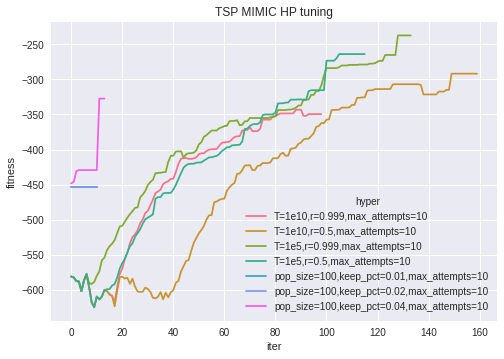

In [31]:
sns.lineplot(data=df_fitness_curve.reset_index(), x="iter", y="fitness", hue="hyper", ci=None).set_title('TSP MIMIC HP tuning')

In [ ]:
df_fitness_curve_list = []

In [ ]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='100', keep_pct='0.1', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]], fast_mimic=False)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='300', keep_pct='0.05', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]], fast_mimic=False)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='200', keep_pct='0.01', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]], fast_mimic=False)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='150', keep_pct='0.1', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]], fast_mimic=False)
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
df_fitness_curve = pd.concat(df_fitness_curve_list)
ht(df_fitness_curve)

In [ ]:
sns.lineplot(data=df_fitness_curve.reset_index(), x="iter", y="fitness", hue="hyper", ci=None).set_title('TSP MIMIC HP tuning')

#### GA

In [39]:
df_fitness_curve_list = []

In [40]:
best_fitness_list, wall_clock_time_list = GA_HP(pop_size='200', mut_prob='0.1', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]])
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

414.6707331261011
1.4716408252716064


In [41]:
best_fitness_list, wall_clock_time_list = GA_HP(pop_size='200', mut_prob='0.2', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]])
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

403.2107071760029
1.482252836227417


In [42]:
df_fitness_curve = pd.concat(df_fitness_curve_list)
ht(df_fitness_curve)

(22, 6)


,fitness,iter,try,hyper,RO,N
0,-414.670733,0,0,"pop_size=200,mut_prob=0.1,max_attempts=10",GA,32
1,-414.670733,1,0,"pop_size=200,mut_prob=0.1,max_attempts=10",GA,32
2,-414.670733,2,0,"pop_size=200,mut_prob=0.1,max_attempts=10",GA,32
3,-414.670733,3,0,"pop_size=200,mut_prob=0.1,max_attempts=10",GA,32
4,-414.670733,4,0,"pop_size=200,mut_prob=0.1,max_attempts=10",GA,32
6,-403.210707,6,0,"pop_size=200,mut_prob=0.2,max_attempts=10",GA,32
7,-403.210707,7,0,"pop_size=200,mut_prob=0.2,max_attempts=10",GA,32
8,-403.210707,8,0,"pop_size=200,mut_prob=0.2,max_attempts=10",GA,32
9,-403.210707,9,0,"pop_size=200,mut_prob=0.2,max_attempts=10",GA,32
10,-403.210707,10,0,"pop_size=200,mut_prob=0.2,max_attempts=10",GA,32


Text(0.5, 1.0, 'TSP GA HP tuning')

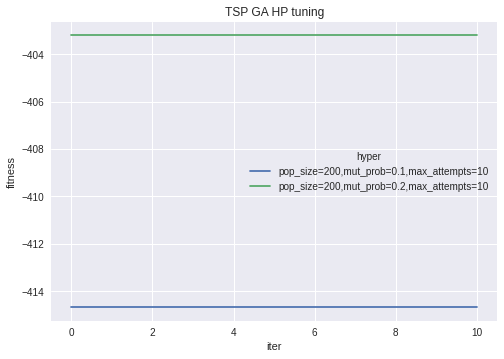

In [43]:
sns.lineplot(data=df_fitness_curve.reset_index(), x="iter", y="fitness", hue="hyper", ci=None).set_title('TSP GA HP tuning')

In [ ]:
best_fitness_list, wall_clock_time_list = GA_HP(pop_size='600', mut_prob='0.2', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]])
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
best_fitness_list, wall_clock_time_list = GA_HP(pop_size='600', mut_prob='0.3', max_attempts='10', N=N, random_seed_list=[random_seed_list[-1]])
best_fitness = sum(best_fitness_list) / len(best_fitness_list)
print(best_fitness)
wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
print(wall_clock_time)

In [ ]:
df_fitness_curve = pd.concat(df_fitness_curve_list)
ht(df_fitness_curve)

In [ ]:
sns.lineplot(data=df_fitness_curve.reset_index(), x="iter", y="fitness", hue="hyper", ci=None).set_title('TSP GA HP tuning')

#### Problem Size

In [48]:
df_fitness_curve_list = []
df_result_list = []

In [49]:
# for N in [20, 40, 50, 80]:   
#     print('N', N)
#     np.random.seed(random_seed_list[-1])
#     coords_list = []
#     for i in range(N):
#         coords_list.append((np.random.rand(), np.random.rand()))
#     fitness = mlrose.TravellingSales(coords = coords_list)

for n in [1,2,3,4]:
# for n in [1,2,4,6]:
# for n in [3]:
    np.random.seed(random_seed_list[-1])
    coords_list_base = [(1, 1), (4, 2), (5, 2), (6, 4), (4, 4), (3, 6), (1, 5), (2, 3)]
    coords_list = [(p[0]+i*10,p[1]+i*10) for i in range(n) for p in coords_list_base]
    N = len(coords_list)
    fitness = mlrose.TravellingSales(coords = coords_list)    
    init_state = np.random.permutation(N)
    problem = mlrose.TSPOpt(length = N, fitness_fn = fitness, maximize=False)
    print('N', N)
    
    print('RHC')
    best_fitness_list, wall_clock_time_list = RHC_HP(restarts='0', max_attempts='10', N=N)
    best_fitness = sum(best_fitness_list) / len(best_fitness_list)
    print(best_fitness)
    wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
    print(wall_clock_time)    
    df_fitness_curve = pd.concat(df_fitness_curve_list)
    df_result_list.append(DataFrame({'RO': 'RHC', 'N': N, 'best_fitness': best_fitness, 'wall_clock_time': wall_clock_time, 'max_iter': df_fitness_curve[(df_fitness_curve['RO']=='RHC')&(df_fitness_curve['N']==N)].groupby('try')['iter'].max().mean()}, index=['N']))
    
    print('SA')
    best_fitness_list, wall_clock_time_list = SA_HP(init_temp='1e5', exp_const='0.999', max_attempts='10', N=N)
    best_fitness = sum(best_fitness_list) / len(best_fitness_list)
    print(best_fitness)
    wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
    print(wall_clock_time)
    df_fitness_curve = pd.concat(df_fitness_curve_list)
    df_result_list.append(DataFrame({'RO': 'SA', 'N': N, 'best_fitness': best_fitness, 'wall_clock_time': wall_clock_time, 'max_iter': df_fitness_curve[(df_fitness_curve['RO']=='SA')&(df_fitness_curve['N']==N)].groupby('try')['iter'].max().mean()}, index=['N']))
    
    print('GA')
    best_fitness_list, wall_clock_time_list = GA_HP(pop_size='600', mut_prob='0.3', max_attempts='10', N=N, random_seed_list=[random_seed])
    best_fitness = sum(best_fitness_list) / len(best_fitness_list)
    print(best_fitness)
    wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
    print(wall_clock_time)
    df_fitness_curve = pd.concat(df_fitness_curve_list)
    df_result_list.append(DataFrame({'RO': 'GA', 'N': N, 'best_fitness': best_fitness, 'wall_clock_time': wall_clock_time, 'max_iter': df_fitness_curve[(df_fitness_curve['RO']=='GA')&(df_fitness_curve['N']==N)].groupby('try')['iter'].max().mean()}, index=['N']))
    
    print('MIMIC')
    best_fitness_list, wall_clock_time_list = MIMIC_HP(pop_size='300', keep_pct='0.05', max_attempts='10', N=N, random_seed_list=[random_seed], fast_mimic=False)
    best_fitness = sum(best_fitness_list) / len(best_fitness_list)
    print(best_fitness)
    wall_clock_time = sum(wall_clock_time_list) / len(wall_clock_time_list)
    print(wall_clock_time)
    df_fitness_curve = pd.concat(df_fitness_curve_list)
    df_result_list.append(DataFrame({'RO': 'MIMIC', 'N': N, 'best_fitness': best_fitness, 'wall_clock_time': wall_clock_time, 'max_iter': df_fitness_curve[(df_fitness_curve['RO']=='MIMIC')&(df_fitness_curve['N']==N)].groupby('try')['iter'].max().mean()}, index=['N']))

N 8
RHC
21.056437875944724
0.0034387826919555662
SA
20.39057380511059
0.006334733963012695
GA


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


17.342617547667327
3.4865989685058594
MIMIC
19.195036913004508
2.450308084487915
N 16
RHC
84.9111957937299
0.011412787437438964
SA


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


88.48652094641828
0.015540528297424316
GA
71.19305043539245
2.6173481941223145
MIMIC
72.12848478493879
5.565044641494751
N 24
RHC
216.86643908585967
0.020037221908569335
SA


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


190.47752531799787
0.031339383125305174
GA
189.43752370223837
6.656919479370117
MIMIC
205.040012572871
9.488606452941895
N 32
RHC
356.0521202177955
0.029909491539001465
SA


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


349.35002999644655
0.04452695846557617
GA
323.5527122963063
5.2678611278533936
MIMIC
380.72144741654455
14.388428926467896


Text(0.5, 1.0, 'TSP 4 ROs N=32')

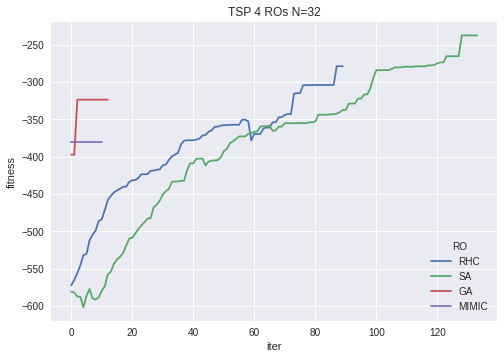

In [50]:
sns.lineplot(data=df_fitness_curve[df_fitness_curve['N']==32].reset_index(), x="iter", y="fitness", hue="RO", ci=None).set_title('TSP 4 ROs N=32')

In [51]:
df_result = pd.concat(df_result_list)
df_result['best_fitness'] = 1 / df_result['best_fitness']

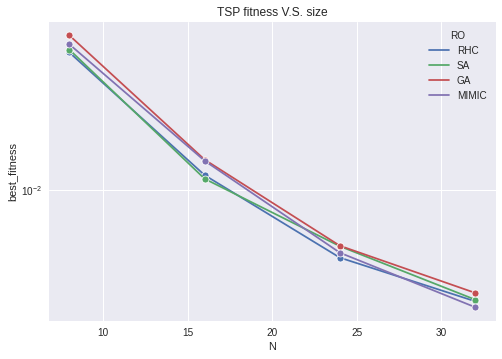

In [52]:
ax = sns.lineplot(data=df_result.reset_index(), x="N", y="best_fitness", hue="RO", marker='o')
ax.set(yscale='log')
ax.set_title('TSP fitness V.S. size')
plt.show();

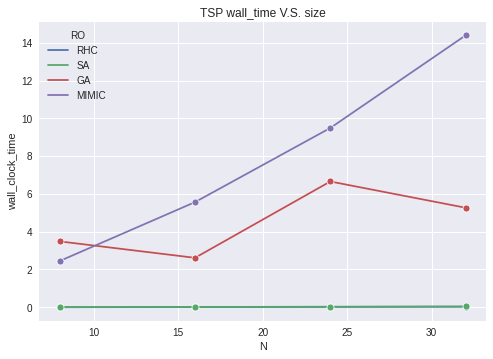

In [53]:
ax = sns.lineplot(data=df_result.reset_index(), x="N", y="wall_clock_time", hue="RO", marker='o')
# ax.set(yscale='log')
ax.set_title('TSP wall_time V.S. size')
plt.show();

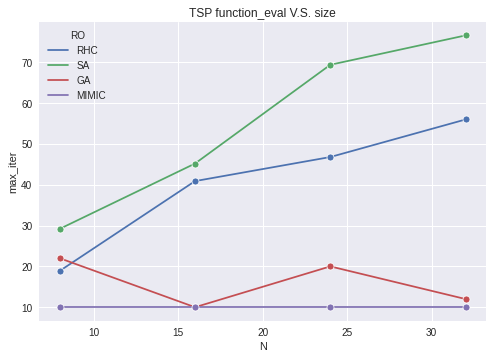

In [54]:
ax = sns.lineplot(data=df_result.reset_index(), x="N", y="max_iter", hue="RO", marker='o')
# ax.set(yscale='log')
ax.set_title('TSP function_eval V.S. size')
plt.show();